<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 16th exercise: <font color="#C70039">TimesFM - Google's Foundational Model for Time Series Forecasting</font>
* Course: <a href="https://www.gernotheisenberg.de/time_series_forecasting.html">Time Series Forecasting (TSF)</a>
* Lecturer: <a href="https://www.gernotheisenberg.de/uebermich.html">Gernot Heisenberg</a>
* Date:   22.06.2025

<img src="./images/TimesFM.png" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation please use English language, too
* This applies to all exercises throughout this course.  

---------------------

### <font color="ce33ff">DESCRIPTION OF THE NOTEBOOK CONTENT</font>:
This notebook will teach you how to implement and use TimesFM, which is Google's foundation model for time series forecasting.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done by using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * understand the output
4. optimize the hyperparameters of timesFM and squeeze out more ogf the model
5. use your own data set and step through the entire sequence by yourself
-----------------------------------------------------------------------------------

In [1]:
import timesfm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

import uuid

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


C:\Users\gheisenb\AppData\Local\anaconda3\envs\timeslm\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\gheisenb\AppData\Local\anaconda3\envs\timeslm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM, likely because python version is 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)].


In [2]:
# as always, set some useful parameters
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

## The Data
This data set contains monthly production data for about 40000 wells in North Dakota (March 2025).

The real world data can be found here: https://www.dmr.nd.gov/oilgas/mprindex.asp

We start by loading the data and selecting the top 2 high-production wells. 
This ensures that the forecast focuses on active sites with meaningful trends.

In [3]:
# Load real oil production data
#df = pd.read_csv("./data/FM/north_dakota_production.csv")
df = pd.read_csv('./data/FM/daily_min_temp.csv')

# rename the columns
df.columns = ['ds', 'y']

# convert the datestamp it to the right pandas type
df['ds'] = pd.to_datetime(df['ds'])

# Add a new column 'unique_id' since TimesFM expects it.
# Hence, you can forecast many time series in one df.
df['unique_id'] = '666'

df.head()

,ds,y,unique_id
0,1981-01-01,20.7,666
1,1981-01-02,17.9,666
2,1981-01-03,18.8,666
3,1981-01-04,14.6,666
4,1981-01-05,15.8,666


## Training data
We split the data into training and test sets using TimeSeriesSplit, so to mean that you have seen how to use this method. It is very useful and you might want to use it it in one of your projects if your go for cross-validation for time series. One we have talked about during the lecture course. However, there are many more ways:

https://medium.com/@kylejones_47003/cross-validation-for-time-series-data-51fd11c38e2b 

##### Description

tscval: initialize a TimeSeriesSplit object that will split the data 5 times, each time with
* an expanding training window and
* a fixed test set size of 10% of the data set.

In [4]:
# train|test split using the TimeSeriesSplit() method
tscval = TimeSeriesSplit(n_splits=5, test_size=int(0.1 * len(df)))
print('tscv=', tscval)

tscv= TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=365)


The gap parameter in the TimeSeriesSplit object from scikit-learn is used to introduce a temporal buffer between the training and test sets — preventing data leakage from future observations into the model's training.

* Without gap:
    * Training and test sets are adjacent.

* What does gap do?
    * When gap > 0, it skips a number of observations immediately after the training set before starting the test set.

* With gap=3:
    * There will be a "hole" of 3 time steps between them.

In [5]:
train_idx, test_idx = list(tscval.split(df))[-1] # takes the last split

# DEBUG
#print('train_idx=',train_idx)
#print('test_idx=',test_idx)

train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]

* tscv.split(df) generates an iterator of (train_index, test_index) pairs.
* list(...)[-1] selects the last split, i.e., the one closest to the present (most recent data).

Now you have two arrays:

* train_idx: indices of the training set.
* test_idx: indices of the test set.

## The TimesFM model
### Initialization

Now we initialize TimesFM, loading a pretrained checkpoint from Hugging Face. 
Hugging Face is a platform and ecosystem for sharing and using machine learning models, data sets 
and tools—especially for transformers and other deep learning architectures.

This gives us access to a large-scale foundation model trained on millions of time series.
Additional reading on the model can be found here:

https://huggingface.co/google/timesfm-2.0-500m-jax

##### <font color = red>NOTE</font>:
For successful downloading on Windows, make sure you turned on 'DeveloperMode':

https://stackoverflow.com/questions/69427548/flutter-pub-get-a-required-privilege-is-not-held-by-the-client/69735375#69735375

In [41]:
# the below code downloads the model from Hugging Face TimesFM checkpoint (only once).
# Cache it locally so future runs are fast.
# Load it into memory, then you are ready for forecasting.

# Initialize the TimesFM Model
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        per_core_batch_size=32,  # Batch size per GPU/TPU core. Higher batch sizes=more parallelism, but needs more memory.
        horizon_len=365,         # Forecasting horizon length
        input_patch_len=32,      # Length of input patches
        output_patch_len=128,    # Length of output patches
        num_layers=50,           # Number of transformer layers. More layers=more expressive model, but slower and heavier
        model_dims=1280,         # Dim. of transformer. A larger number means more powerful model, again at the cost of memory/speed.
        use_positional_embedding=False
    ),
    checkpoint=timesfm.TimesFmCheckpoint(huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
)

Fetching 5 files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


### Forecasting
We use the downloaded TimesFM model to generate the forecasts. 
The model processes the train_df, making predictions for the test_df.

In [28]:
# Generate forecasts using the TimesFM model on the given training data
forecast_df = tfm.forecast_on_df(
    inputs=train_df,# Input DataFrame containing the time-series data for training 
    freq="D",       # Frequency of the time-series data (e.g., daily)
    value_name="y", # Name of the column containing the values to be forecasted
    num_jobs=-1,    # Number of parallel jobs to use for forecasting (-1 uses all available cores)
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [42]:
# print the forecasting table and have a closer look.
forecast_df

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,666,1990-01-01,13.648251,10.872475,11.845036,12.543238,13.108221,13.648251,14.205306,14.801439,15.501462,16.473639
1,666,1990-01-02,14.246275,11.237771,12.272853,13.033703,13.655497,14.246275,14.842136,15.488102,16.259964,17.322117
2,666,1990-01-03,14.921835,11.794999,12.885695,13.649961,14.310851,14.921835,15.544674,16.229988,17.053112,18.168556
3,666,1990-01-04,14.871265,11.688943,12.776653,13.565796,14.249129,14.871265,15.523041,16.227268,17.043453,18.182400
4,666,1990-01-05,14.750011,11.537590,12.641703,13.432220,14.120670,14.750011,15.395636,16.098825,16.907770,18.050840
...,...,...,...,...,...,...,...,...,...,...,...,...
360,666,1990-12-27,11.057050,9.389709,9.927896,10.316623,10.673529,11.057050,11.478134,12.010736,12.793392,14.220783
361,666,1990-12-28,11.063695,9.391053,9.931132,10.332277,10.675992,11.063695,11.499434,12.036711,12.816630,14.235610
362,666,1990-12-29,11.047642,9.369949,9.895450,10.300817,10.668173,11.047642,11.482728,12.018289,12.800937,14.207962
363,666,1990-12-30,10.979845,9.300240,9.844245,10.243739,10.595008,10.979845,11.408818,11.948826,12.722069,14.137856


# Interpretation of forcasting table

* unique_id:
    * A grouping key (e.g., a time series identifier).
    * In this table, all rows have the same ID 666, suggesting it's one single time series (compare above)
* ds:
    * The date stamp for the observation.
* timesfm:
    * The mean forecast or central point estimate from the TimeSFM model for that date ds.
* timesfm-q-0.X:
    * These are quantile forecasts—predictions at various uncertainty levels (10% to 90%).
    * Lower quantiles capture more pessimistic (lower) scenarios, while higher quantiles capture more optimistic (higher) ones.

##### Example of how to interpret the forecasts
Let’s take the row for 1990-01-01 as an example:
* Mean forecast (timesfm):      13.648251
* 10% quantile (timesfm-q-0.1): 10.872475
* 90% quantile (timesfm-q-0.9): 16.473639

Hence, on January 1st, 1990, the model predicts a most likely value of ~13.65. However, there's a 90% chance the true value lies between ~10.87 and ~16.47, assuming the model's probabilistic assumptions hold.

## Visualization
Visualize the results, comparing actual temperature with the TimesFM forecast.

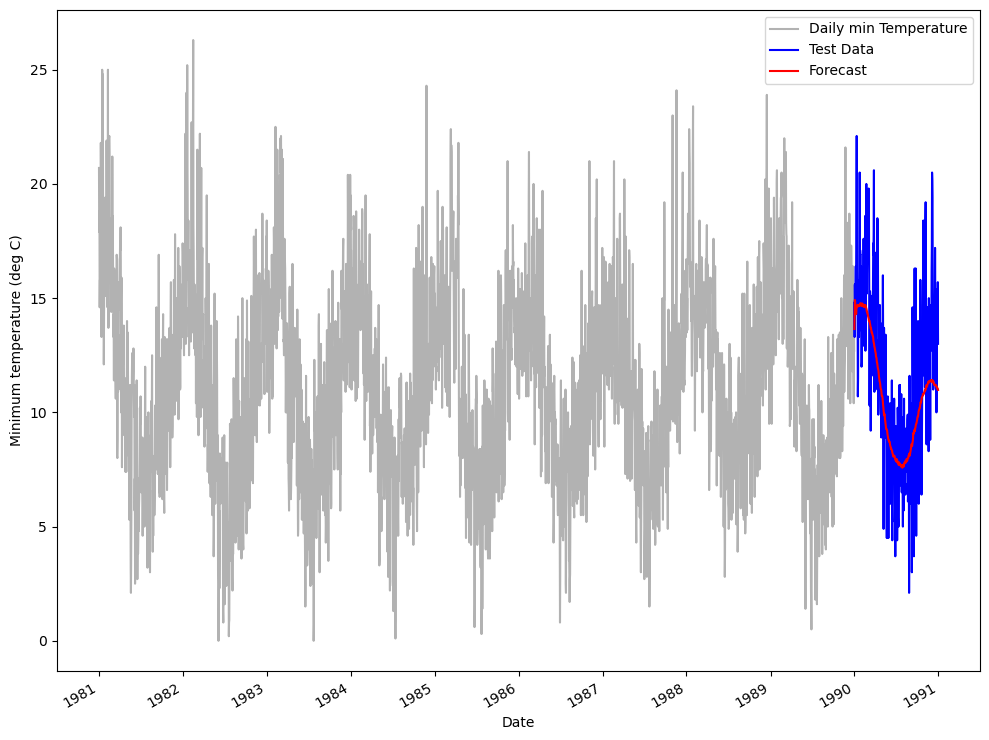

In [30]:
# Plot results
fig, ax = plt.subplots()
ax.set_xlabel('Date')
ax.set_ylabel('Minimum temperature (deg C)')
plt.plot(train_df["ds"], train_df["y"], label="Daily min Temperature",  color="black", alpha=0.3)
plt.plot(test_df["ds"], test_df["y"], label="Test Data", color="blue")
plt.plot(forecast_df["ds"], forecast_df["timesfm"], label="Forecast",  color="red")

plt.legend()
fig.autofmt_xdate()
plt.tight_layout()

#### Create a Baseline

In [31]:
# As always: the last year of the training set is repeated as the forecast for next year
test_df['baseline'] = train_df['y'][-365:].values

#### MAE Evaluation

In [32]:
timesfm_mae = mean_absolute_error(test_df['y'], forecast_df["timesfm"])
baseline_mae = mean_absolute_error(test_df['y'], test_df['baseline'])

print("timesfm_mae=", round(timesfm_mae,2))
print("baseline_mae", round(baseline_mae,2))

timesfm_mae= 2.13
baseline_mae 2.87


### Results
The baseline returns a MAE of 2.87, while the MAE achieved by the TimesFM model is 2.13, meaning that it is indeed better
than the baseline. 
The interpretation says that, on average, our model predicts the daily minimum temperature with a difference of 2.13 degrees Celsius, 
either above or below the observed value.